In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Creating a Custom Dataset for your files

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Dataloader

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


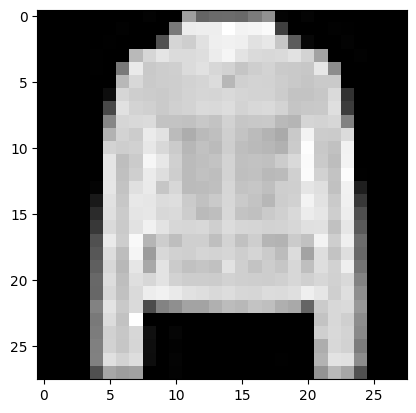

Label: 4


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d lefterislymp/neuralsntua-image-captioning
!unzip /content/neuralsntua-image-captioning.zip

cp: kaggle.json: No such file or directory
kaggle.json
chmod: /root/.kaggle/kaggle.json: No such file or directory
100%|█████████████████████████████████████▉| 4.08G/4.08G [05:15<00:00, 15.3MB/s]
100%|██████████████████████████████████████| 4.08G/4.08G [05:15<00:00, 13.9MB/s]
unzip:  cannot find or open /content/neuralsntua-image-captioning.zip, /content/neuralsntua-image-captioning.zip.zip or /content/neuralsntua-image-captioning.zip.ZIP.


In [8]:

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from PIL import Image
import os
import pandas as pd

!pip install transformers
from transformers import AutoTokenizer

In [ ]:
class KaggleImageCaptioningDataset(Dataset):
    def __init__(self, train_captions, root_dir, transform=None, bert_model='distilbert-base-uncased', max_len=512):
        self.df = pd.read_csv(train_captions, header=None, sep='|')
        self.root_dir = root_dir
        self.transform = transform
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model)
        self.max_len = max_len

        self.images = self.df.iloc[:,0]
        self.captions = self.df.iloc[:,2]

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_id = self.images[idx]
        path_to_image = os.path.join(self.root_dir, image_id)
        image = Image.open(path_to_image).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        tokenized_caption = self.tokenizer(caption,
                                           padding='max_length',  # Pad to max_length
                                           truncation=True,  # Truncate to max_length
                                           max_length=self.max_len,
                                           return_tensors='pt')['input_ids']

        return image, tokenized_caption

In [ ]:
root_dir = '/content/flickr30k-images-ecemod/image_dir'
train_captions = '/content/train_captions.csv'
bert_model = 'distilbert-base-uncased'
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.PILToTensor()])
train_dataset = KaggleImageCaptioningDataset(train_captions=train_captions,
                                             root_dir=root_dir,
                                             transform=transform,
                                             bert_model=bert_model)
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          num_workers=2,
                          shuffle=True)

In [ ]:

for batch_num, (image, caption) in enumerate(train_loader):
    if batch_num > 3:
        break
    print(f'batch number {batch_num} has {image.shape[0]} images and correspondingly {caption.shape[0]} tokenized captions')

In [ ]:

!pip install torchdata
import torchdata.datapipes as dp
from torch.utils.data.backward_compatibility import worker_init_fn
from torch.utils.data import DataLoader

In [ ]:

training_csv = '/content/train_captions.csv'
train_dp = dp.iter.FileOpener([training_csv])
train_dp = train_dp.parse_csv(delimiter='|')
train_dp = train_dp.shuffle(buffer_size=2000)
train_dp = train_dp.sharding_filter()

In [9]:

max_len = 512
root_dir = '/content/flickr30k-images-ecemod/image_dir'

def apply_image_transforms(image):

    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.PILToTensor()])
    return transform(image)

def open_image_from_imagepath(row):
    image_id, _, caption = row
    path_to_image = os.path.join(root_dir, image_id)
    image = Image.open(path_to_image).convert('RGB')
    image = apply_image_transforms(image)
    tokenized_caption = tokenizer(caption,
                                  padding='max_length',  # Pad to max_length
                                  truncation=True,  # Truncate to max_length
                                  max_length=max_len,
                                  return_tensors='pt')['input_ids']
    return {'image':image, 'caption':tokenized_caption}


train_dp = train_dp.map(open_image_from_imagepath)
train_loader = DataLoader(dataset=train_dp, shuffle=True, batch_size=32, num_workers=2, worker_init_fn=worker_init_fn)

NameError: name 'train_dp' is not defined

In [ ]:
num_epochs = 1
bert_model = 'distilbert-base-uncased'    # use any model of your choice
tokenizer = AutoTokenizer.from_pretrained(bert_model)
for epoch in range(num_epochs):
    for batch_num, batch_dict in enumerate(train_loader):
        if batch_num > 2:
            break

        images, captions = batch_dict['image'], batch_dict['caption']
        print(f'Batch {batch_num} has {images.shape[0]} images and correspondingly {captions.shape[0]} captions')

In [ ]:
from transformers import AutoTokenizer

bert_model = 'distilbert-base-uncased'    # use any model of your choice
tokenizer = AutoTokenizer.from_pretrained(bert_model)
tokenizer('hi how are you')

In [ ]:
bert_model = 'distilbert-base-uncased'    # use any model of your choice
tokenizer = AutoTokenizer.from_pretrained(bert_model)